# Synthesis of a pseudo-mainnet

## Set up packages

In [1]:
suppressMessages({
    require(data.table, quietly=TRUE)
    require(ggplot2, quietly=TRUE)
    require(igraph, quietly=TRUE)
    require(jsonlite, quietly=TRUE)
    require(magrittr, quietly=TRUE)
})

## Read data files

### Probes of mainnet nodes

In [2]:
ptNodes <- fread("pt_nodes.csv.gz", stringsAsFactors=TRUE)
ptNodes %>% summary

                                                                id      
 0049eca4703be755cef74ed20e1815b50b5fa0ceb07c6b822c78355dd12fdaa6:   1  
 0078d0f5d825d8946e0809e85fe0f21589294cae912104b3ca9f0e4bb93552c3:   1  
 008c441677a37d339c96a2bf2c9aa377e2411a00eb9d4588e3362043f0d7b744:   1  
 012200f2a61b1d302998036a06091f074f95125848e9caff9f0d23e392538936:   1  
 012c09d9b08f7c26d9076a0aea43ead69de74de251de49c6ba67e40d0613053b:   1  
 01567bed7019b7452a243cb66b3e8cc433c2eafe4d7569e49227d61bcfd6d33f:   1  
 (Other)                                                         :2195  
               n2n_version   peer_sharing      asn                   country   
 NodeToNodeVersionV10:   1   f: 745       Min.   :   209   Germany       :528  
 NodeToNodeVersionV11:   1   t:1456       1st Qu.: 14061   United States :502  
 NodeToNodeVersionV13: 869                Median : 20860   Canada        :154  
 NodeToNodeVersionV14:1330                Mean   : 61266   Japan         :123  
                

### Probes of mainnet edges

In [3]:
ptEdges <- fread("pt_edges.csv.gz", stringsAsFactors=TRUE)
ptEdges %>% summary

                                                              source     
 99f4b029b0864e19334824015c8d05b34c34353ab7fe36e9da91689ceb512b66:   67  
 7e0520b4ebf8159bd1e219d49fc847efc9fe54332cc36aa5ac2350020c2a4939:   64  
 624d8747537834fe5aa3da126f5647904f2425fb002c72be6fe811fbd671412b:   61  
 73a4c479d08b254dab522708a611981c48e8323ae39ab6ad838c30ba3c8c8811:   59  
 1b80ab54864c57bf4f1e9646d30edf48e4d98e8d70ecaacac89adb3a48be5726:   57  
 4a5c7640e2e4f40870dfe3df1fe942e90f718394bd68de31e5ec9730c5ece414:   57  
 (Other)                                                         :49569  
                                                              target     
 99f4b029b0864e19334824015c8d05b34c34353ab7fe36e9da91689ceb512b66:  194  
 2d8b0cb5e44c3e746e7e29fb025dcb258aaf4df658f41c11bdc6824a9059fb84:  185  
 9b88f53637710f0b577b5cc060e67ceb1fddbee24c18f600b4497829d2e2323f:  181  
 d651218f17c10c040eb944416864971abd396ff8142bda7e2d97e26a7fc3a987:  177  
 d0cca0575254a0c01423d9532b4223e4dc467

### Snapshot of mainnet stakepools

In [4]:
poolCountries <- fread("pool_country.csv.gz", stringsAsFactors=TRUE)
poolCountries %>% summary

    epoch_no        country    no_of_pools         stake           
 Min.   :524   Australia: 1   Min.   :  1.00   Min.   :    120272  
 1st Qu.:524   Austria  : 1   1st Qu.:  1.00   1st Qu.:  32641441  
 Median :524   Belgium  : 1   Median :  5.00   Median :  94785845  
 Mean   :524   Bolivia  : 1   Mean   : 37.09   Mean   : 616847011  
 3rd Qu.:524   Brazil   : 1   3rd Qu.: 23.50   3rd Qu.: 517550850  
 Max.   :524   Canada   : 1   Max.   :537.00   Max.   :7077609940  
               (Other)  :29                                        

### Boundary boxes for countries

In [5]:
countryBoundingBoxes <- fread("country-boundingboxes.csv.gz", stringsAsFactors=TRUE)
countryBoundingBoxes %>% summary

        country    ISO3166 country code    longmin              latmin       
 AT         :  1      :248              Min.   :-179.9850   Min.   :-78.000  
 AV         :  1   ABW:  1              1st Qu.: -59.9168   1st Qu.: -7.080  
 Afghanistan:  1   AE :  1              Median :  10.0000   Median : 10.000  
 Albania    :  1   AT :  1              Mean   :  -0.1206   Mean   :  9.275  
 Algeria    :  1   ATG:  1              3rd Qu.:  39.6500   3rd Qu.: 32.858  
 Andorra    :  1   AV :  1              Max.   : 176.1000   Max.   : 62.000  
 (Other)    :248   BD :  1                                                   
    longmax              latmax           Wrapped   
 Min.   :-174.4170   Min.   :-54.386          :242  
 1st Qu.:   0.4457   1st Qu.:  9.544   WRAPPED: 12  
 Median :  32.5915   Median : 21.000                
 Mean   :  35.9674   Mean   : 23.508                
 3rd Qu.:  75.0000   3rd Qu.: 42.918                
 Max.   : 180.0000   Max.   : 89.000                
     

### ASN to ASN round-trip pings

In [6]:
asn_rtt_stat <- fread("asn_rtt_stat.csv.gz")
asn_rtt_stat %>% summary

      asn1             asn2           rtt_cnt            rtt_avg         
 Min.   :     0   Min.   :     0   Min.   :       1   Min.   :     0.03  
 1st Qu.:  4493   1st Qu.: 34347   1st Qu.:       6   1st Qu.:    30.22  
 Median : 12276   Median : 57073   Median :    2169   Median :    95.40  
 Mean   : 26245   Mean   :115727   Mean   :    6231   Mean   :   114.11  
 3rd Qu.: 32167   3rd Qu.:203296   3rd Qu.:    4326   3rd Qu.:   173.23  
 Max.   :401332   Max.   :401612   Max.   :44991955   Max.   :301077.44  
                                                                         
    rtt_std             rtt_min             rtt_max       
 Min.   :     0.00   Min.   :     0.00   Min.   :      0  
 1st Qu.:     0.82   1st Qu.:    22.19   1st Qu.:     56  
 Median :     3.64   Median :    75.87   Median :    154  
 Mean   :    17.62   Mean   :   101.80   Mean   :    424  
 3rd Qu.:    13.39   3rd Qu.:   161.65   3rd Qu.:    287  
 Max.   :173798.40   Max.   :301077.44   Max.   :35923

### Intra ASN round-trip pings

In [7]:
intra_rtt_stat <- fread("intra_rtt_stat.csv.gz")
intra_rtt_stat %>% summary

    rtt_cnt             rtt_avg         rtt_std         rtt_min 
 Min.   :145057189   Min.   :80.41   Min.   :103.5   Min.   :0  
 1st Qu.:145057189   1st Qu.:80.41   1st Qu.:103.5   1st Qu.:0  
 Median :145057189   Median :80.41   Median :103.5   Median :0  
 Mean   :145057189   Mean   :80.41   Mean   :103.5   Mean   :0  
 3rd Qu.:145057189   3rd Qu.:80.41   3rd Qu.:103.5   3rd Qu.:0  
 Max.   :145057189   Max.   :80.41   Max.   :103.5   Max.   :0  
    rtt_max      
 Min.   :249626  
 1st Qu.:249626  
 Median :249626  
 Mean   :249626  
 3rd Qu.:249626  
 Max.   :249626  

### Mainnet stake

In [8]:
mainnetStake <- fread("mainnet-stake.csv.gz")[order(`Epoch`, `Stake [Lovelace]`)][`Stake [Lovelace]` > 0]
mainnetStake %>% summary

     Epoch         Pool           Stake [Lovelace]         Stake [Fraction]   
 Min.   :500   Length:2884        Min.   :         11118   Min.   :0.000e+00  
 1st Qu.:500   Class :character   1st Qu.:    1442483670   1st Qu.:6.300e-08  
 Median :500   Mode  :character   Median :  127668335529   Median :5.596e-06  
 Mean   :500                      Mean   : 7923945372784   Mean   :3.467e-04  
 3rd Qu.:500                      3rd Qu.: 4675668176601   3rd Qu.:2.048e-04  
 Max.   :500                      Max.   :78570314564092   Max.   :3.438e-03  

## Create ASN-level totals

### Compare node countries to pool countries

All of the pool countries appear in the list of node countries.

In [9]:
poolCountries[!(`country` %in% ptNodes$`country`), unique(`country`)]

factor(0)
35 Levels: Australia Austria Belgium Bolivia Brazil Canada China ... United States

Twenty-one of the node countries do not appear in the list of pool countries.

In [10]:
ptNodes[!(`country` %in% poolCountries$`country`), unique(`country`)]

[1]                Estonia        Argentina      Viet Nam       Czechia       
 [6] Italy          Portugal       Slovenia       Greece         Denmark       
[11] Chile          Cayman Islands Israel         Malaysia       Luxembourg    
[16] New Caledonia  Iran           Malta          Bulgaria       Mexico        
[21] Peru          
56 Levels:  Argentina Australia Austria Belgium Bolivia Brazil ... Viet Nam

### Use hot-deck imputation to assign missing nodes to countries and ASNs

If the country is missing, then the ASN is also missing.

In [11]:
ptNodes[, .N, .(`Has Country`=`country`!="", `Has ASN`=!is.na(`asn`))]

Has Country,Has ASN,N
<lgl>,<lgl>,<int>
FALSE,FALSE,64
TRUE,TRUE,2137


In [12]:
nonMissing <- ptNodes[`country` != "", .(`country`, `asn`)]
nonMissing %>% dim

[1] 2137    2

In [13]:
nrow(nonMissing)

[1] 2137

In [14]:
assignments <- sample(1:nrow(nonMissing), ptNodes[`country`=="", .N])

In [15]:
ptNodes[`country` =="", `:=`(`country`=nonMissing[assignments, `country`], `asn`=nonMissing[assignments, `asn`])]

### Distribute the stake among the ASNs

In [16]:
nodeFractions <- ptNodes[, .(`no_of_nodes`=.N), .(`country`, `asn`)][, .(`asn`, `no_of_nodes`, `fraction`=`no_of_nodes`/sum(`no_of_nodes`)), .(`country`)]
nodeFractions %>% head

country,asn,no_of_nodes,fraction
<fct>,<int>,<int>,<dbl>
Japan,2514,11,0.0859375
Japan,16509,48,0.3750000
Japan,131965,5,0.0390625
Japan,31898,4,0.0312500
Japan,2516,4,0.0312500
Japan,141995,9,0.0703125


Randomly distribute the pools to ASNs according to a multinomial distribution weighted by the number of nodes in the ASN.

In [17]:
rpools <- function(no_of_pools, fractions) {
    if (sum(no_of_pools) == 0)
        0
    else
        as.numeric(rmultinom(1, no_of_pools, fractions))
}

Distribute the country's stake in proportion to the distribution of pools within the ASN.

In [18]:
asnPools <- poolCountries[
    nodeFractions,
    on="country"
][
    `no_of_pools`>0,
    .(`asn`, `no_of_nodes`, `no_of_pools`=rpools(`no_of_pools`, `fraction`), `stake`), 
    .(`country`)
][,
  .(`asn`, `no_of_nodes`, `no_of_pools`, `stake`=`stake`*`no_of_pools`/sum(`no_of_pools`)),
  .(`country`)
]
asnPools %>% head

country,asn,no_of_nodes,no_of_pools,stake
<fct>,<int>,<int>,<dbl>,<dbl>
Japan,2514,11,7,88602694
Japan,16509,48,37,468328525
Japan,131965,5,2,25315055
Japan,31898,4,3,37972583
Japan,2516,4,3,37972583
Japan,141995,9,7,88602694


Check that the resulting disaggregation matches the original marginal distribution.

In [19]:
(
    asnPools[, .(`no_of_pools`=sum(`no_of_pools`), `stake`=round(sum(`stake`))), .(`country`=as.character(`country`))][order(`country`)] == 
    poolCountries[, .(`no_of_pools`, `stake`), .(`country`=as.character(`country`))][order(`country`)]
) %>% all

[1] TRUE

#### Adjust the number of pools to aproximately match the mainnet registration

Count to total number of pools

In [20]:
asnPools[, sum(no_of_pools)]

[1] 1298

So, only about half the the ~2750 pools are represented in the dataset. To correct for this, double the pool count.

In [21]:
poolCount <- 2750

In [22]:
asnPools[, `no_of_pools`:=round(`no_of_pools`*poolCount/asnPools[, sum(`no_of_pools`)])]

In [23]:
poolCount <- asnPools[, sum(no_of_pools)]
poolCount

[1] 2720

## Create nodes

We want 10,000 nodes.

In [24]:
nodeCount <- 10000

However, the data set should not contain any block producers, so we need to reserve `poolCount` indices for those block producers. We'll also reserve `poolCount` for the second relay.

### Resample to increase the number of nodes

In [25]:
extraNodes <- sample(nrow(ptNodes), nodeCount - poolCount - nrow(ptNodes), replace=TRUE)

In [26]:
expandedNodes <- rbind(
    ptNodes[, .(`country`, `asn`, `id`)],
    ptNodes[extraNodes, .(`country`, `asn`, `id`)]
)
expandedNodes %>% dim

[1] 7280    3

### Assign stakepools

In [27]:
rpools <- function(no_of_pools, no_of_nodes) {
    if (no_of_pools[1] == 0)
        0
    else if (no_of_pools[1] > no_of_nodes)
        rep(1, no_of_nodes)
    else {
        selection <- rep(0, no_of_nodes)
        pools <- sample(1:no_of_nodes, no_of_pools[1])
        selection[pools] <- 1
        selection
    }
}

In [28]:
nodeStakes <- asnPools[
    expandedNodes, on=c("country", "asn")
][,
    .(`id`, `country`, `asn`, `no_of_pools`=fcoalesce(`no_of_pools`,0), `stake`=fcoalesce(`stake`,0))
][, 
  .(`id`, `stake`=rpools(`no_of_pools`, .N) * `stake`/ `no_of_pools`), 
  .(`country`, `asn`)
]
nodeStakes[`stake` > 0, .N]

[1] 2657

Some of the pools were lost in this process, but they were tiny pools.

### Assign block producers, relays, and other nodes

In [29]:
nodeStakes <- rbind(
    nodeStakes[`stake` > 0, .(`country`, `asn`, `id`, `stake`, `kind`=factor("BPROD"), `kindex`=.I)],
    nodeStakes[`stake` > 0, .(`country`, `asn`, `id`, `stake`=0, `kind`="RELAY1", `kindex`=.I)],
    nodeStakes[`stake` > 0, .(`country`, `asn`, `id`, `stake`=0, `kind`="RELAY2", `kindex`=.I)],
    nodeStakes[`stake` == 0, .(`country`, `asn`, `id`, `stake`=0, `kind`="OTHER", `kindex`=NA)]
)[1:nodeCount]
nodeStakes %>% nrow

[1] 10000

In [30]:
nodeStakes[, .N, .(`kind`)]

kind,N
<fct>,<int>
BPROD,2657
RELAY1,2657
RELAY2,2657
OTHER,2029


### Add geographic locations

First make sure that the names align.

In [31]:
nodeStakes[!(`country` %in% countryBoundingBoxes$`country`)]

country,asn,id,stake,kind,kindex
<fct>,<int>,<fct>,<dbl>,<fct>,<int>


In [32]:
rlong <- function(longmin, longmax, wrapped) {
    if (wrapped)
        (runif(1, longmax, 360 + longmin) + 180) %% 360 - 180
    else
        runif(1, longmin, longmax)
}

In [33]:
rlat <- function(latmin, latmax) {
    runif(1, latmin, latmax)
}

In [34]:
nodes <- nodeStakes[
    countryBoundingBoxes[, .(`country`, `longmin`, `longmax`, `latmin`, `latmax`, `wrapped`=`Wrapped`=="WRAPPED")], 
    on="country",
    nomatch=0
][,
  .(`index`=.I-1, `country`, `asn`, `id`, `kind`, `kindex`, `stake`, `long`=mapply(rlong, `longmin`, `longmax`, `wrapped`), `lat`=mapply(rlat, `latmin`, `latmax`))
][,
  .(`index`=as.integer(`index`), `subindex`=1:.N, `kindex`, `kind`, `stake`, `long`, `lat`),
  .(`country`, `asn`, `id`)
][
    order(-`stake`)
]
nodes %>% nrow

[1] 10000

In [35]:
nodes %>% head

country,asn,id,index,subindex,kindex,kind,stake,long,lat
<fct>,<int>,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>
United Arab Emirates,16509,b9a646720fe83a1ed251d983345bde7d85c2075cc8485fd50f9df64caaba84de,0,1,1853,BPROD,32164497,55.35406,25.30690
United Arab Emirates,16509,3f3419343e3bf26b407a71ca702e7c71e4b9d37895184e52c2aef8680e3b05b5,1,1,1854,BPROD,32164497,55.65587,24.91369
Lithuania,16125,509f46e0017bd349bdb79715ea5946cf8a999800912147665aeffafe1fe82b26,6382,1,2354,BPROD,30137226,27.18983,55.93470
Lithuania,16125,509f46e0017bd349bdb79715ea5946cf8a999800912147665aeffafe1fe82b26,6383,2,2355,BPROD,30137226,27.00442,54.24828
Lithuania,16125,509f46e0017bd349bdb79715ea5946cf8a999800912147665aeffafe1fe82b26,6384,3,2356,BPROD,30137226,22.51673,54.23938
Lithuania,16125,509f46e0017bd349bdb79715ea5946cf8a999800912147665aeffafe1fe82b26,6385,4,2357,BPROD,30137226,22.71173,55.36866


Most of the stake is preserved.

In [36]:
nodes[, sum(`stake`)] / poolCountries[, sum(as.numeric(`stake`))]

[1] 0.9749432

## Adjust the stake distribution to match mainnet

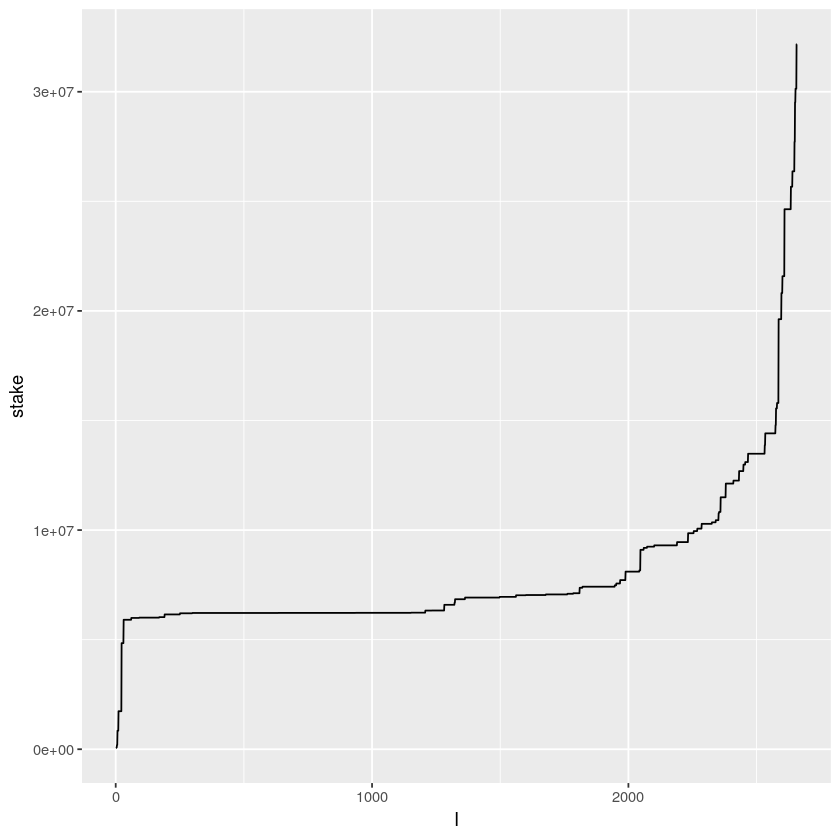

In [37]:
ggplot(nodes[`stake` > 0][order(`stake`)][, .(.I, `stake`)], aes(x=`I`, y=`stake`)) + geom_line()

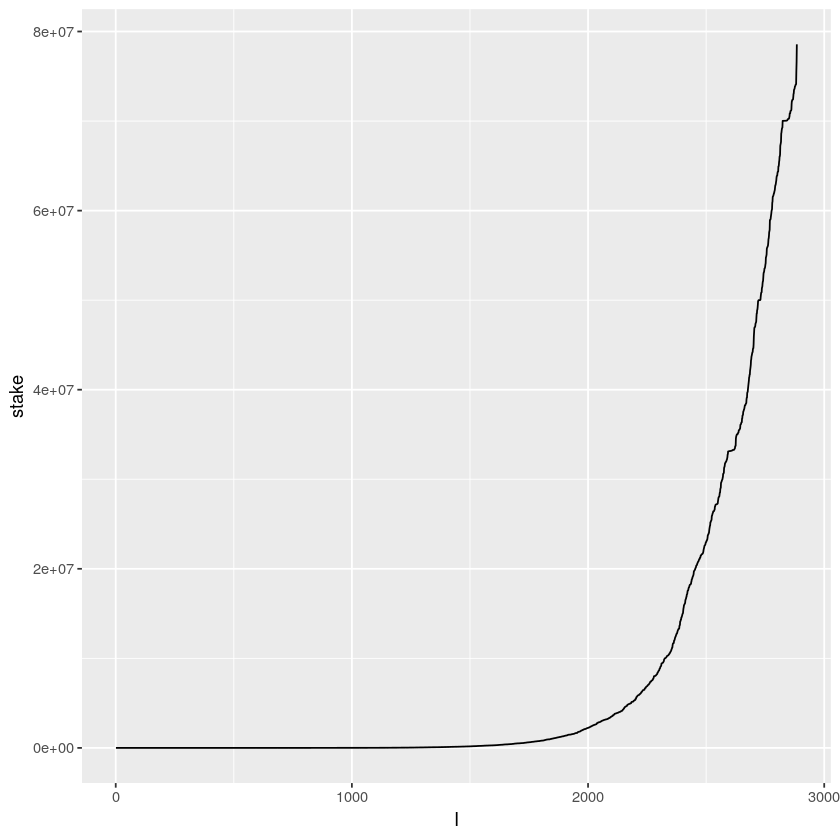

In [38]:
ggplot(mainnetStake[`Epoch` == 500][order(`Stake [Lovelace]`)][, .(.I, `stake`=`Stake [Lovelace]`/1e6)], aes(x=`I`, y=`stake`)) + geom_line()

In [39]:
nodes <- rbind(
    nodes[`stake` == 0],
    nodes[order(-`stake`)][`stake` > 0, .(`country`, `asn`, `id`, `index`, `subindex`, `kindex`, `kind`, `long`, `lat`, `srank`=.I)][
        mainnetStake[`Epoch` == 500][order(-`Stake [Lovelace]`)][, .(`srank`=.I, `stake`=`Stake [Lovelace]`/1e6)],
        on="srank",
        nomatch=0
    ][, .(`country`, `asn`, `id`, `index`, `subindex`, `kindex`, `kind`, `stake`, `long`, `lat`)]
)
nodes %>% nrow

[1] 10000

## Create edges

### Examine summary statistics for edge connectivity

In [40]:
ptEdges[, .(`degree`=.N), .(`source`)][, `degree`] %>% summary

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   31.00   36.00   34.46   40.00   67.00 

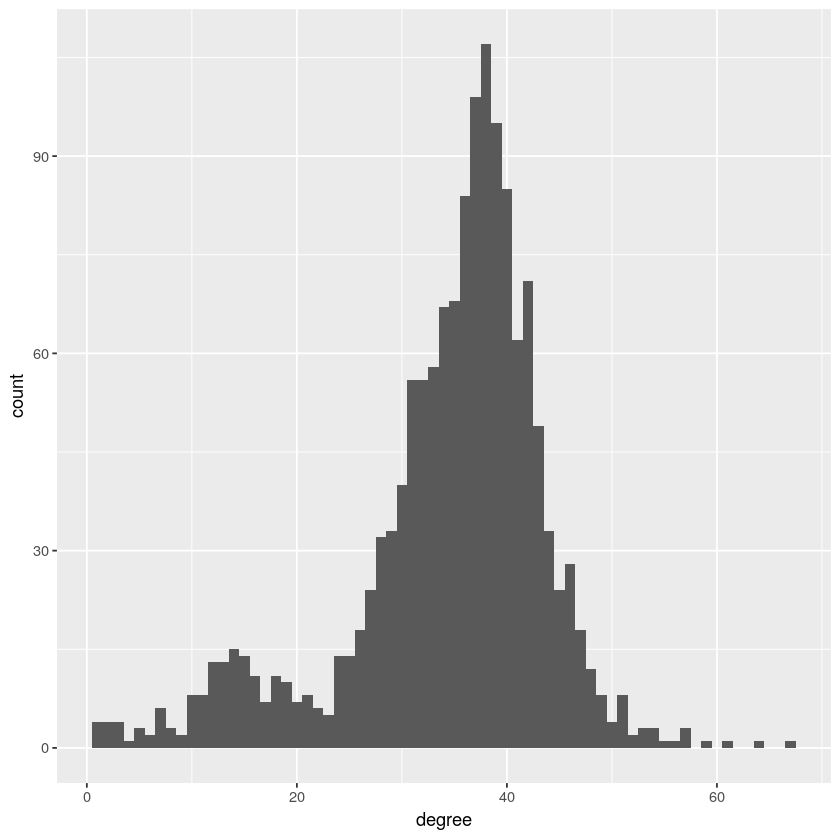

In [41]:
ggplot(
    ptEdges[, .(`degree`=.N), .(`source`)],
    aes(x=`degree`)
) +
    geom_histogram(binwidth=1)

### Connect the empirically observed edges, but not for the second relay because it needs more randomization

In [42]:
edges <- nodes[`kind` %in% c("RELAY1", "OTHER"), .(`tindex`=`index`, `tasn`=`asn`, `subindex`, `target`=`id`)][
    nodes[`kind` %in% c("RELAY1", "OTHER"), .(`sindex`=`index`, `sasn`=`asn`, `subindex`, `source`=`id`)][
        ptEdges, on="source", allow.cartesian=TRUE
    ], 
    on=c("target", "subindex"),
    nomatch=0
][,
  .(`source_index`=`sindex`, `source_asn`=`sasn`, `target_index`=`tindex`, `target_asn`=`tasn`)
]
edges %>% nrow

[1] 31798

### Connect the second relay randomly

In [43]:
edges <- rbind(
    edges,
    nodes[`kind` == "RELAY2", .(`tindex`=`index`, `asn`)][
        nodes[`kind` != "BPROD", .(`sindex`=`index`, `asn`)], 
        on="asn", 
        allow.cartesian=TRUE
    ][
        `tindex` != `sindex`,
        .(`tindex`, `asn`, `copy`=1:.N),
        .(`sindex`)
    ][
        `copy` <= 10,
        .(`source_index`=`sindex`, `source_asn`=`asn`, `target_index`=`tindex`, `target_asn`=`asn`)
    ]
)
edges %>% nrow

[1] 99977

### Ensure that each node connects to at least one other node

In [44]:
disconnected <- nodes[`kind` != "BPROD" & !(`index` %in% edges[, unique(`source_index`)]), .(`source_index`=`index`, `source_asn`=`asn`)]
disconnected %>% nrow

[1] 1

In [45]:
redges <- function(missings) {
    nodes[
        missings[, .(`source_index`, `source_asn`, `target_index`=sample(nodes[`kind` != "BPROD", `index`], .N, replace=TRUE))], 
        on=c("index" = "target_index")
    ][,
        .(`source_index`, `source_asn`, `target_index`=`index`, `target_asn`=`asn`)
    ]
}

In [46]:
edges <- rbind(edges, redges(disconnected))

In [47]:
poorlyConnected <- function()
    edges[, .(`degree`=.N), .(`source_index`, `source_asn`)][`degree` < 20][, .(`source_index`, `source_asn`)]

In [48]:
for (i in 1:20) {
    deficient <- poorlyConnected()
    edges <- rbind(edges, redges(deficient))
}
poorlyConnected() %>% nrow

[1] 0

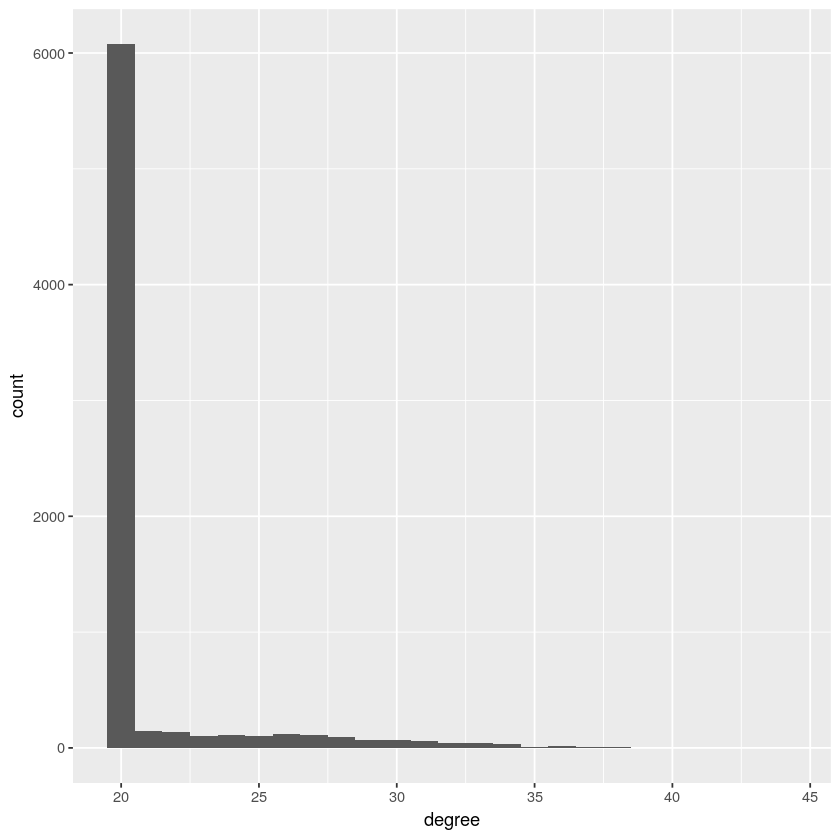

In [49]:
ggplot(
    edges[, .(`degree`=.N), .(`source_index`)],
    aes(x=`degree`)
) +
    geom_histogram(binwidth=1)

We could smear the spike out, but the recommended node configuration suggests 20 active peers.

### Repeat in the reverse direction

#### Ensure that each node connects to at least one other node

In [50]:
disconnected <- nodes[`kind` != "BPROD" & !(`index` %in% edges[, unique(`target_index`)]), .(`target_index`=`index`, `target_asn`=`asn`)]
disconnected %>% nrow

[1] 0

In [51]:
redgesReverse <- function(missings) {
    nodes[
        missings[, .(`target_index`, `target_asn`, `source_index`=sample(nodes[`kind` != "BPROD", `index`], .N, replace=TRUE))], 
        on=c("index" = "source_index")
    ][,
        .(`source_index`=`index`, `source_asn`=`asn`, `target_index`, `target_asn`)
    ]
}

In [52]:
edges <- rbind(edges, redgesReverse(disconnected))

In [53]:
poorlyConnectedReverse <- function()
    edges[, .(`degree`=.N), .(`target_index`, `target_asn`)][`degree` < 20][, .(`target_index`, `target_asn`)]

In [54]:
for (i in 1:20) {
    deficient <- poorlyConnectedReverse()
    edges <- rbind(edges, redgesReverse(deficient))
}
poorlyConnectedReverse() %>% nrow

[1] 0

### Give every node ten more random peers

In [55]:
for (i in 1:10) {
    nonBprods <- nodes[`kind` != "BPROD"]
    edges <- rbind(
        edges, 
        redges(
            nonBprods[
                sample(nrow(nonBprods), nrow(nonBprods), replace=TRUE),
                .(`source_index`=`index`, `source_asn`=`asn`)
            ]
        )
    )
}

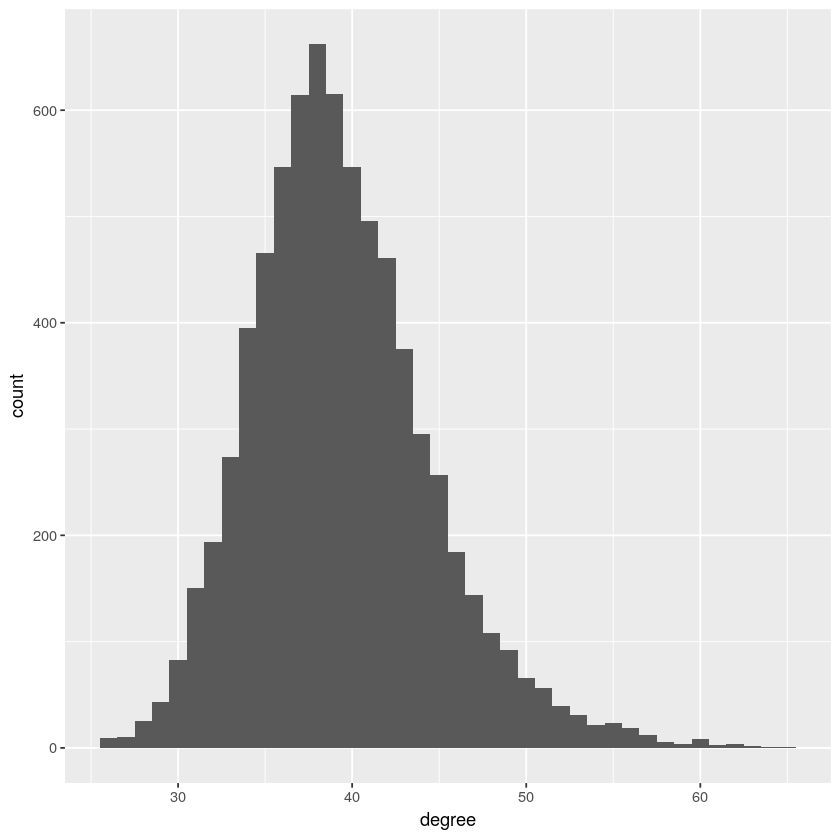

In [56]:
ggplot(
    edges[, .(`degree`=.N), .(`source_index`)],
    aes(x=`degree`)
) +
    geom_histogram(binwidth=1)

In [57]:
edges[, .(`degree`=.N), .(`source_index`)] %>% summary

  source_index      degree     
 Min.   :   2   Min.   :26.00  
 1st Qu.:3318   1st Qu.:36.00  
 Median :5153   Median :39.00  
 Mean   :5328   Mean   :39.37  
 3rd Qu.:8164   3rd Qu.:42.00  
 Max.   :9999   Max.   :65.00  

In [58]:
edges %>% nrow

[1] 289082

### Check that the graph is connected

In [59]:
g <- graph_from_data_frame(edges[, .(`source_index`, `target_index`)])

In [60]:
is.connected(g, mode="strong")

[1] TRUE

In [61]:
g <- graph_from_data_frame(edges[, .(`target_index`, `source_index`)])

In [62]:
is.connected(g, mode="strong")

[1] TRUE

## Assign latencies

### Assign as many latencies as possible at the ASN to ASN level

In [63]:
rrtt <- function(rtt_min, rtt_max, rtt_avg, rtt_std) {
    if (is.na(rtt_std))
        rtt_avg / 2
    else
        max(rtt_min, min(rtt_max, rnorm(1, rtt_avg, rtt_std))) / 2
}

In [64]:
latencies <- rbind(
    asn_rtt_stat[edges, on=c("asn1" = "source_asn", "asn2" = "target_asn"), nomatch=0],
    asn_rtt_stat[edges, on=c("asn2" = "source_asn", "asn1" = "target_asn"), nomatch=0]
)[,
    .(
        `latency`=mapply(rrtt, `rtt_min`, min(`rtt_max`, 1000), min(`rtt_avg`, 1000), `rtt_std`)
    ),
    .(
        `source_index`,
        `target_index`
    )
]
latencies %>% summary

  source_index   target_index     latency       
 Min.   :   2   Min.   :   2   Min.   :  0.000  
 1st Qu.:2967   1st Qu.: 855   1st Qu.:  2.052  
 Median :4209   Median :3807   Median :  6.006  
 Mean   :4490   Mean   :3676   Mean   : 21.403  
 3rd Qu.:5779   3rd Qu.:5088   3rd Qu.: 25.822  
 Max.   :9999   Max.   :9999   Max.   :500.000  

### Assign intra ASN latencies for edges that don't yet have latencies

In [65]:
latencies <- rbind(
    latencies,
    latencies[edges, on=.NATURAL][
        is.na(`latency`) & `source_asn` == `target_asn`,
        .(`latency`=rrtt(intra_rtt_stat$rtt_min, intra_rtt_stat$rtt_max, intra_rtt_stat$rtt_avg, intra_rtt_stat$rtt_std)),
        .(`source_index`, `target_index`)
    ]
)
latencies %>% summary

  source_index   target_index     latency       
 Min.   :   2   Min.   :   2   Min.   :  0.000  
 1st Qu.:3074   1st Qu.: 847   1st Qu.:  2.144  
 Median :4462   Median :3810   Median :  7.357  
 Mean   :4790   Mean   :3739   Mean   : 24.913  
 3rd Qu.:6790   3rd Qu.:5378   3rd Qu.: 38.375  
 Max.   :9999   Max.   :9999   Max.   :500.000  

### Assign remaining latencies

In [66]:
generic_rtt <- asn_rtt_stat[, .(`rtt_avg`=mean(`rtt_avg`), `rtt_std`=mean(`rtt_std`, na.rm=TRUE))]
generic_rtt

rtt_avg,rtt_std
<dbl>,<dbl>
114.1144,17.62252


In [67]:
latencies <- rbind(
    latencies,
    latencies[edges, on=.NATURAL][is.na(`latency`)][, .(`latency`=rrtt(50, 1000, generic_rtt$`rtt_avg`, generic_rtt$`rtt_std`)), .(`source_index`, `target_index`)]
)[, .(`latency`=mean(`latency`)), .(`source_index`, `target_index`)]
latencies %>% summary

  source_index   target_index     latency       
 Min.   :   2   Min.   :   2   Min.   :  0.000  
 1st Qu.:3299   1st Qu.:1506   1st Qu.:  6.372  
 Median :5163   Median :4599   Median : 46.435  
 Mean   :5329   Mean   :4750   Mean   : 39.429  
 3rd Qu.:8168   3rd Qu.:7297   3rd Qu.: 60.298  
 Max.   :9999   Max.   :9999   Max.   :500.000  

### Ensure that latencies between different ASNs are at least 5 milliseconds

In [68]:
latencies <- latencies[edges, on=.NATURAL, nomatch=0]

In [69]:
latencies[`source_asn` == `target_asn` & `latency` < 5, `latency`:=5+`latency`]

### Ensure that no latency is less than 0.05 ms

In [70]:
latencies[`latency` < 0.1, `latency`:=0.05+`latency`]

### Ensure that there are no duplicate edges

In [71]:
latencies %>% nrow

[1] 289082

In [72]:
latencies <- latencies[
    `source_index` != `target_index`, 
    .(`latency`=mean(`latency`)), 
    .(`source`=`source_index`, `target`=`target_index`)
]

In [73]:
latencies %>% nrow

[1] 288128

### View the distribution of latencies

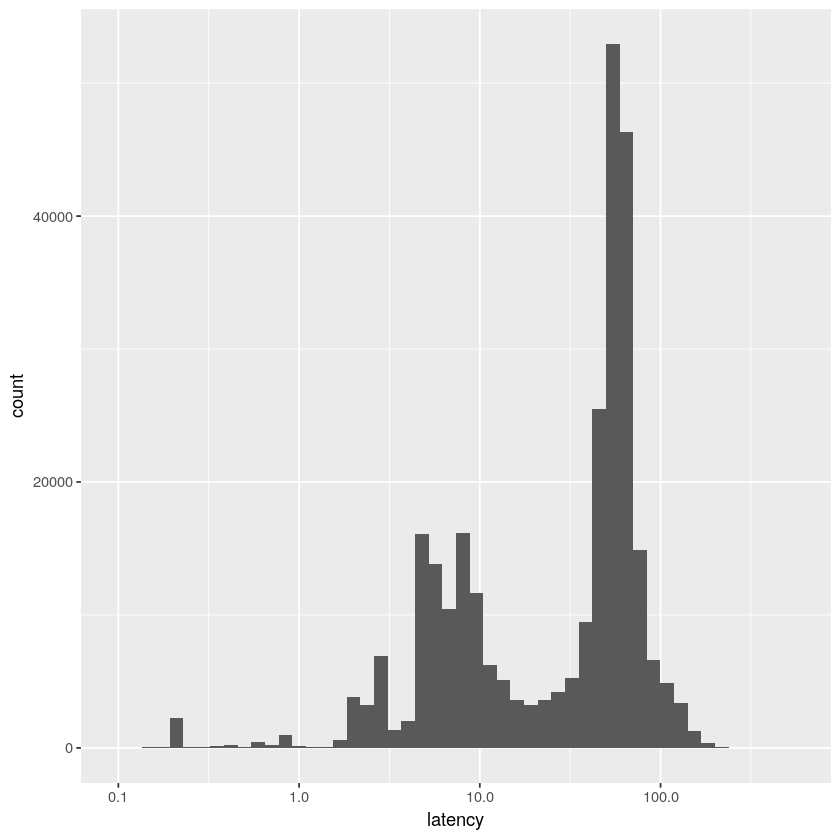

In [74]:
ggplot(latencies, aes(x=`latency`)) + geom_histogram(bins=50) + scale_x_log10()

### Add the edges between block producers and their relays

In [75]:
latencies <- rbind(
    latencies,
    nodes[`kind` == "BPROD", .(`source`=`index`, `kindex`)][
        nodes[`kind` == "RELAY1", .(`target`=`index`, `kindex`)],
        on="kindex"
    ][, .(`source`, `target`, `latency`=runif(.N, 0.05, 0.25)/8)],
    nodes[`kind` == "BPROD", .(`target`=`index`, `kindex`)][
        nodes[`kind` == "RELAY1", .(`source`=`index`, `kindex`)],
        on="kindex"
    ][, .(`source`, `target`, `latency`=runif(.N, 0.05, 0.25)/8)],
    nodes[`kind` == "BPROD", .(`source`=`index`, `kindex`)][
        nodes[`kind` == "RELAY2", .(`target`=`index`, `kindex`)],
        on="kindex"
    ][, .(`source`, `target`, `latency`=runif(.N, 0.05, 0.25)/8)],
    nodes[`kind` == "BPROD", .(`target`=`index`, `kindex`)][
        nodes[`kind` == "RELAY2", .(`source`=`index`, `kindex`)],
        on="kindex"
    ][, .(`source`, `target`, `latency`=runif(.N, 0.05, 0.25)/8)]
)
latencies %>% nrow

[1] 298756

### Symmetrize the latencies

In [76]:
bidirectional <- merge(latencies, latencies, by.x=c("source", "target"), by.y=c("target", "source"), all=TRUE)
bidirectional %>% nrow

[1] 575912

In [77]:
bidirectional[!is.na(`latency.x`) & !is.na(`latency.y`) & `latency.x` < `latency.y`, `latency.x`:=`latency.y`]

In [78]:
latencies <- bidirectional[!is.na(`latency.x`), .(`source`, `target`, `latency`=`latency.x`)]
latencies %>% nrow

[1] 298756

### Patch up locations that violate the triangle inequality

In [79]:
g <- graph_from_data_frame(latencies[, .(`source`=as.character(`source`), `target`=as.character(`target`), `weight`=`latency`)])
g %>% summary

IGRAPH 674960f DNW- 10000 298756 -- 
+ attr: name (v/c), weight (e/n)


In [80]:
for (pass in 1:10) {
    changed <- 0
    for (src in latencies[, sort(unique(`source`))]) {
        targets <- latencies[`source` == src, .(`target`=as.character(`target`), `latency`)]
        shortestLatencies <- distances(g, as.character(src), targets$`target`, mode="all") %>% as.numeric
        replacements <- targets$`latency` > shortestLatencies
        if (any(replacements)) {
            latencies[`source` == src, `latency`:=ifelse(replacements, 0.99 * shortestLatencies, targets$`latency`)]
            changed <- changed + 1
        }
    }
    if (changed == 0)
        break
}
changed == 0

[1] 2

### Rescale the latencies because the triangle correction reduced them by too much

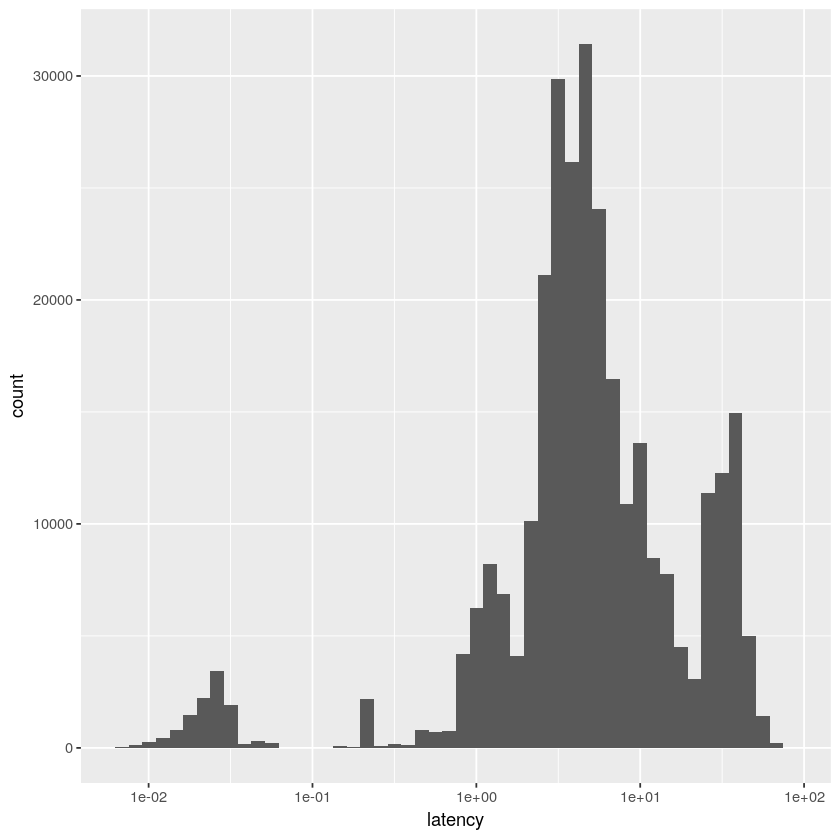

In [81]:
ggplot(latencies, aes(x=`latency`)) + geom_histogram(bins=50) + scale_x_log10()

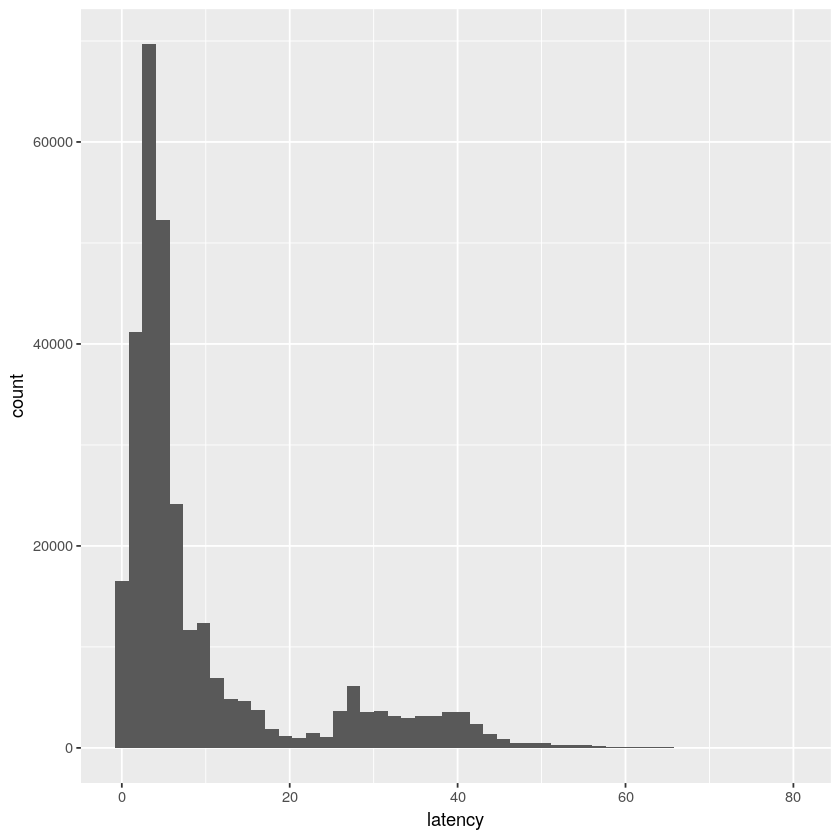

In [82]:
ggplot(latencies, aes(x=`latency`)) + geom_histogram(bins=50)

In [83]:
latencies %>% summary

     source         target        latency        
 Min.   :   0   Min.   :   0   Min.   : 0.00666  
 1st Qu.:3258   1st Qu.:2063   1st Qu.: 2.82788  
 Median :5146   Median :4586   Median : 4.72158  
 Mean   :5302   Mean   :4743   Mean   : 9.62199  
 3rd Qu.:7725   3rd Qu.:7294   3rd Qu.: 9.96674  
 Max.   :9999   Max.   :9999   Max.   :79.59697  

In [84]:
latencies[, `latency`:=8*`latency`]

In [85]:
latencies %>% summary

     source         target        latency        
 Min.   :   0   Min.   :   0   Min.   :  0.0533  
 1st Qu.:3258   1st Qu.:2063   1st Qu.: 22.6230  
 Median :5146   Median :4586   Median : 37.7726  
 Mean   :5302   Mean   :4743   Mean   : 76.9759  
 3rd Qu.:7725   3rd Qu.:7294   3rd Qu.: 79.7339  
 Max.   :9999   Max.   :9999   Max.   :636.7758  

## Export the results

### CSV files

In [86]:
fwrite(nodes[, .(`index`, `kind`, `stake`, `long`, `lat`)], "nodes-v1.csv")

In [87]:
fwrite(latencies, "edges-v1.csv")

### Leios topology file

Assume to 1 Gps bandwidth for all connections

In [88]:
bandwidth <- 1 * 1e9 / 8
bandwidth

[1] 1.25e+08

Assume 6 cpu cores

In [89]:
cpus <- 6

Create the JSON for the topology

In [90]:
makeTopology <- function(nodes, latencies, bandwidth, cpus) {
    nodeData <- list()
    for (i in 1:nrow(nodes)) {
        src <- nodes[i, `index`]
        edgeData <- list()
        edgeRows <- latencies[`source` == src, .(`target`=paste0("node-",`target`), `latency`)]
        for (j in 1:nrow(edgeRows))
            edgeData[[edgeRows[j, `target`]]] <- as.list(edgeRows[j, list(`bandwidth-bytes-per-second`=unbox(bandwidth), `latency-ms`=unbox(`latency`))])
        nodeData[[paste0("node-", src)]] <-
            list(
                `location` = c(nodes[i, `long`], nodes[i, `lat`]),
                `cpu-core-count` = unbox(cpus),
                `stake` = unbox(nodes[i, round(`stake`)]),
                `producers` = edgeData
            )
    }
    list(`nodes` = nodeData)
}

In [91]:
topology <- makeTopology(nodes, latencies, bandwidth, cpus)

In [92]:
topology$`nodes`$`node-0` %>% toJSON

{"location":[55.3541,25.3069],"cpu-core-count":6,"stake":78570315,"producers":{"node-2":{"bandwidth-bytes-per-second":125000000,"latency-ms":0.24},"node-4":{"bandwidth-bytes-per-second":125000000,"latency-ms":0.2101}}} 

In [93]:
write_json(topology, "topology-v1.yaml")